# CNN con GloVe

En este notebook se va a utilizar una red neuronal convolucional (CNN) para clasificar el texto de comentarios de Reddit, utilizando el modelo preentrenado de word embeddings GloVe.

Los embeddings de palabras son una representación de palabras en un espacio n-dimensional, donde palabras similares están cerca unas de otras. Los embeddings de palabras preentrenados son útiles para tareas de procesamiento de lenguaje natural, ya que permiten a los modelos aprender de los patrones de palabras en un corpus grande de texto.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import to_categorical
from matplotlib_inline.backend_inline import set_matplotlib_formats


2024-05-01 19:49:09.309625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Cargar datos y dividirlos entre training y validation

In [2]:
df = pd.read_csv('./data/goemotions_clean.csv', sep=",")
df.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


In [3]:
# Dividir el dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['emotion'], test_size=0.2, random_state=0)

In [4]:
np.round(len(X_train) / len(df), 2)

0.8

Comprobamos que la distribución de las clases es similar en train y validation

# Preprocesamiento de los datos

1. **Tokenización de Textos**:
   - **Tokenizador**: Usamos un objeto `Tokenizer` de Keras, que se inicializa para manejar un máximo de 5000 palabras distintas y emplea un token especial `<OOV>` para manejar palabras fuera del vocabulario (aquellas palabras que no se encuentran entre las 5000 más frecuentes).
   - **Fit del Tokenizador**: La función `fit_on_texts` se aplica a los datos de entrenamiento (`X_train`). Esto permite al tokenizador aprender el índice de todas las palabras presentes en el conjunto de entrenamiento. El tokenizador crea un mapeo de palabras a índices enteros, donde cada palabra única se asigna a un número entero único.

2. **Conversión de Textos a Secuencias**:
   - **Textos a Secuencias**: Convertimos los textos en secuencias de números enteros usando `texts_to_sequences`. Cada texto (una serie de palabras) se convierte en una serie de enteros, donde cada entero representa la palabra en el texto según el índice aprendido por el tokenizador.

3. **Padding de Secuencias**:
   - **Cálculo de la Longitud Máxima**: Calculamos la longitud de la secuencia más larga entre todos los textos de entrenamiento y prueba. Esto es necesario para estandarizar las longitudes de todas las secuencias, lo cual es un requisito para entrenar modelos de aprendizaje profundo.
   - **Aplicación de Padding**: Usando `pad_sequences`, estandarizamos la longitud de todas las secuencias. Las secuencias que son más cortas que la máxima longitud calculada se rellenan con ceros al final (padding 'post') para alcanzar la longitud estándar. Esto asegura que todas las entradas tengan la misma forma, lo cual es necesario para el procesamiento por la red neuronal.

4. **Resultados de la Función**:
   - La función devuelve las secuencias de entrenamiento y prueba ya rellenadas y estandarizadas, la longitud máxima de secuencia encontrada, y el tamaño total del vocabulario (el número de palabras únicas en el entrenamiento más uno para el token de padding).
   - También devuelve el objeto `tokenizer`, que puede ser útil para otras tareas de preprocesamiento o para inversión de las secuencias a texto si es necesario más adelante.

Este proceso de preprocesamiento es esencial para preparar los datos de texto para modelos que requieren entradas numéricas de longitud fija, como las CNNs, permitiendo que el modelo aprenda características importantes del texto mediante la estructura convolucional.

In [5]:
def tokenization(tokenizer: Tokenizer, X_train: pd.Series, X_test: pd.Series) -> tuple[np.ndarray, np.ndarray, int, int]:
    # Fit tokenizer on train set
    tokenizer.fit_on_texts(X_train)

    # Convert text to sequences for both train and test sets
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)

    # Get length of the longest sequence
    max_seq_len = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

    # Get vocabulary size
    vocab_size = len(tokenizer.word_index) + 1  # +1 for zero padding
    
    # Applying padding to both train and test sets
    train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
    test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

    return train_padded, test_padded, max_seq_len, vocab_size, tokenizer

In [6]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val)

# Construir el modelo

### 1. Capa de Embedding (Incrustación)
- **Objetivo**: Transformar los índices de palabras (enteros) en vectores densos de un espacio vectorial más pequeño y continuo. Esto ayuda a la red a entender mejor las relaciones semánticas entre las palabras.
- **`num_tokens`**: Número de palabras distintas en el vocabulario.
- **`embedding_dim`**: Dimensión del espacio vectorial de los embeddings. 
- **`embeddings_initializer`**: Inicializa la matriz de embeddings con una matriz preexistente (`embedding_matrix`), obtenida de entrenamientos previos (como GloVe).
- **`input_length`**: Longitud máxima de las secuencias de entrada. Todas las secuencias deben ser normalizadas a esta longitud.
- **`trainable`**: Fija a `False` para no actualizar los embeddings durante el entrenamiento, útil cuando se desean preservar los valores preentrenados.

### 2. Capa Convolucional
- **`Conv1D`**: Aplica filtros convolucionales que se desplazan a lo largo de la secuencia de entrada. Es útil para detectar patrones locales (como n-gramas en texto).
- **`filters`**: Número de filtros convolucionales (cada uno produce una salida diferente).
- **`kernel_size`**: Tamaño del kernel; 3 indica que cada filtro mira 3 palabras consecutivas a la vez.
- **`strides`**: Número de posiciones que el filtro se mueve cada vez. Aquí es 1, moviéndose una palabra a la vez.
- **`padding`**: "same" significa que la salida tendrá la misma longitud que la entrada, ajustando con ceros si es necesario.

### 3. Capa de Pooling
- **`MaxPooling1D`**: Reduce la dimensionalidad de la entrada seleccionando el valor máximo de cada ventana de características, lo que ayuda a hacer el modelo más manejable computacionalmente y más general.

### 4. Capas de Dropout
- **`Dropout(0.5)`**: Se utiliza para reducir el sobreajuste "apagando" aleatoriamente la mitad de las conexiones entre capas durante el entrenamiento, lo que fuerza a la red a no depender de ninguna entrada específica.

### 5. Capa de Aplanado
- **`Flatten`**: Convierte las matrices de características multidimensionales en un vector único, permitiendo que los datos se ingresen a capas densas (totalmente conectadas).

### 6. Capas Densas
- **Primera Capa Densa**: Tiene 32 unidades y usa activación ReLU para introducir no linealidades.
- **Capa de Salida**: Tiene 24 unidades (correspondientes a 24 clases posibles), usando la función de activación softmax para obtener una distribución de probabilidad sobre las clases de salida.

Este modelo es típicamente usado en tareas de clasificación donde el contexto y la secuencialidad de las palabras son importantes, aprovechando las capacidades de las CNN para captar patrones locales en los datos de entrada.

In [8]:
def load_glove_embeddings(path_to_glove_file: str) -> dict:
    """
    Loads GloVe embeddings.

    Args:
    -------
    path_to_glove_file: str
        Path to the GloVe embeddings file.

    Returns:
    -------
    embeddings_index: dict
        Dictionary where each key is a word and each value is the corresponding embedding.
    """
    embeddings_index = {}
    with open(path_to_glove_file, encoding="utf8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    return embeddings_index

def create_embedding_matrix(embeddings_index: dict, tokenizer: keras.preprocessing.text.Tokenizer, num_tokens: int, embedding_dim: int) -> tuple[np.ndarray, int, int]:
    """
    Creates an embedding matrix.

    Args:
    -------
    embeddings_index: dict
        Dictionary where each key is a word and each value is the corresponding embedding.
    tokenizer: keras.preprocessing.text.Tokenizer
        Tokenizer to use.
    num_tokens: int
        Number of tokens.
    embedding_dim: int
        Dimension of the embeddings.

    Returns:
    -------
    embedding_matrix: np.array
        Embedding matrix.
    hits: int
        Number of words in the vocabulary that are also in the embeddings.
    misses: int
        Number of words in the vocabulary that are not in the embeddings.
    """
    # Initialize hits and misses to 0
    # i) hits: number of words in the vocabulary that are also in the embeddings
    # ii) misses: number of words in the vocabulary that are not in the embeddings
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    return embedding_matrix, hits, misses

In [9]:
num_tokens = vocab_size + 1
# Define embedding dimension for GloVe (this is needed in order to load the corresponding embeddings)
embedding_dim = 100

path_to_glove_file = '/Volumes/mSDXC-BMR/glove.twitter.27B/glove.twitter.27B.100d.txt'

In [10]:
embeddings_index = load_glove_embeddings(path_to_glove_file)
print(f"Found {len(embeddings_index)} word vectors.")

Found 1193515 word vectors.


In [11]:
embedding_matrix, hits, misses = create_embedding_matrix(embeddings_index, tokenizer, num_tokens, embedding_dim)
print(f"Converted {hits} words ({misses} misses)")

Converted 22557 words (4989 misses)


In [12]:
model = Sequential()

# Embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_seq_len,
    trainable=False,
)

model.add(embedding_layer)

# Convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Flatten and classifier
model.add(Flatten(input_shape=(max_seq_len, embedding_dim)))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))

# Output layer
model.add(Dense(24, activation="softmax"))

In [13]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

## Entrenar modelo

In [14]:
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [15]:
model_path = os.path.join(models_dir, "cnn_model_glove.keras")

El `ModelCheckpoint` guarda automáticamente el mejor modelo mientras entrena, así que siempre tienes la versión que mejor desempeño tuvo en el proceso de validación.

In [16]:
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [17]:
all_possible_labels = np.unique(np.concatenate((y_train, y_val)))  # Recolecta todas las etiquetas únicas

label_encoder = LabelEncoder()
label_encoder.fit(np.append(all_possible_labels, 'desconocido'))  # Agrega 'desconocido' al final

# Transformar las etiquetas de entrenamiento directamente
y_train_encoded = label_encoder.transform(y_train)

# Verificar y reemplazar las etiquetas desconocidas en validación
y_val_safe = np.where(np.isin(y_val, label_encoder.classes_), y_val, 'desconocido')
y_val_encoded = label_encoder.transform(y_val_safe)

In [18]:
num_classes = len(label_encoder.classes_)

y_train_encoded = to_categorical(y_train_encoded, num_classes)
y_val_encoded = to_categorical(y_val_encoded, num_classes)

In [19]:
print("train_padded shape:", train_padded.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("val_padded shape:", val_padded.shape)
print("y_val_encoded shape:", y_val_encoded.shape)

train_padded shape: (86084, 19)
y_train_encoded shape: (86084, 24)
val_padded shape: (21522, 19)
y_val_encoded shape: (21522, 24)


In [20]:
history = model.fit(
    train_padded, y_train_encoded,
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(val_padded, y_val_encoded),
    callbacks=[mc]
)

Epoch 1/30


1342/1346 [============================>.] - ETA: 0s - loss: 2.7310 - acc: 0.2713
Epoch 1: val_loss improved from inf to 2.56551, saving model to ./models/cnn_model_glove.keras
1346/1346 [==============================] - 69s 49ms/step - loss: 2.7308 - acc: 0.2714 - val_loss: 2.5655 - val_acc: 0.2916
Epoch 2/30
1343/1346 [============================>.] - ETA: 0s - loss: 2.5734 - acc: 0.2890
Epoch 2: val_loss improved from 2.56551 to 2.47024, saving model to ./models/cnn_model_glove.keras
1346/1346 [==============================] - 54s 40ms/step - loss: 2.5731 - acc: 0.2891 - val_loss: 2.4702 - val_acc: 0.3064
Epoch 3/30
1345/1346 [============================>.] - ETA: 0s - loss: 2.5216 - acc: 0.2974
Epoch 3: val_loss improved from 2.47024 to 2.42592, saving model to ./models/cnn_model_glove.keras
1346/1346 [==============================] - 54s 40ms/step - loss: 2.5216 - acc: 0.2973 - val_loss: 2.4259 - val_acc: 0.3099
Epoch 4/30
1344/1346 [============================>.] - ETA: 0s 

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 100)           2754800   
                                                                 
 conv1d (Conv1D)             (None, 19, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 9, 64)             0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dropout_1 (Dropout)         (None, 576)               0         
                                                        

_________________________________________________________________
None


In [22]:
def plot_metric_curves(epochs, train_curve, val_curve, train_color, val_color, metric, epochs_interval: int = 1):
    # Set graphics format as svg
    set_matplotlib_formats('svg')
    # Add grid
    sns.set_style("whitegrid")
    # Set figure size
    plt.figure(figsize=(12,8), dpi=200)
    # Plot curves
    plt.plot(epochs, train_curve, color=train_color, linewidth=2, label=f'Training {metric.lower()}')
    plt.plot(epochs, val_curve, color=val_color, linewidth=2, label=f'Validation {metric.lower()}')
    # Set title and labels
    plt.title(f'Training and validation {metric.lower()}', fontsize=20)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel(metric.capitalize(), fontsize=15)
    # Show epoch values in x-axis in the specified interval
    plt.xticks(epochs[::epochs_interval])
    # Set max x-axis as the last epoch + 1
    plt.xlim(0, epochs[-1] + 1)
    # Remove top and right spines
    sns.despine(left=True, bottom=True)
    # Put the legend outside of the plot
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    plt.show()
    return

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

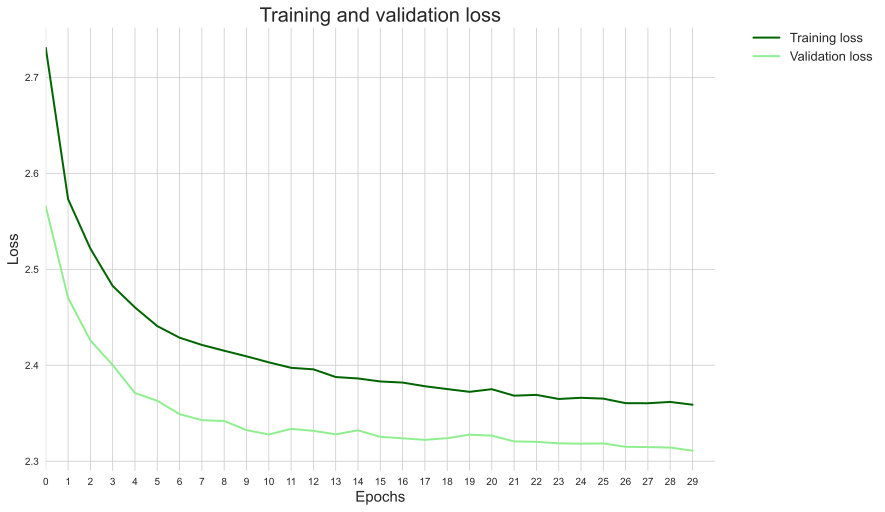

In [24]:
plot_metric_curves(epochs, loss, val_loss, "darkgreen", "lightgreen", "Loss", 1)

En esta gráfica se puede ver que tanto la pérdida de entrenamiento como la de validación disminuyen constantemente, lo cual es bueno ya que indica que el modelo está aprendiendo y mejorando en la tarea de predecir los datos de entrenamiento. Es cierto que durante todas las epochs hay una el valor de validación es ligeramente superior, pero no es lo suficientemente significativo como para considerar que el modelo está sobreajustando.

La pérdida de validación es menor que la de entrenamiento, lo cual es un buen indicador de que el modelo está generalizando bien a datos no vistos. 

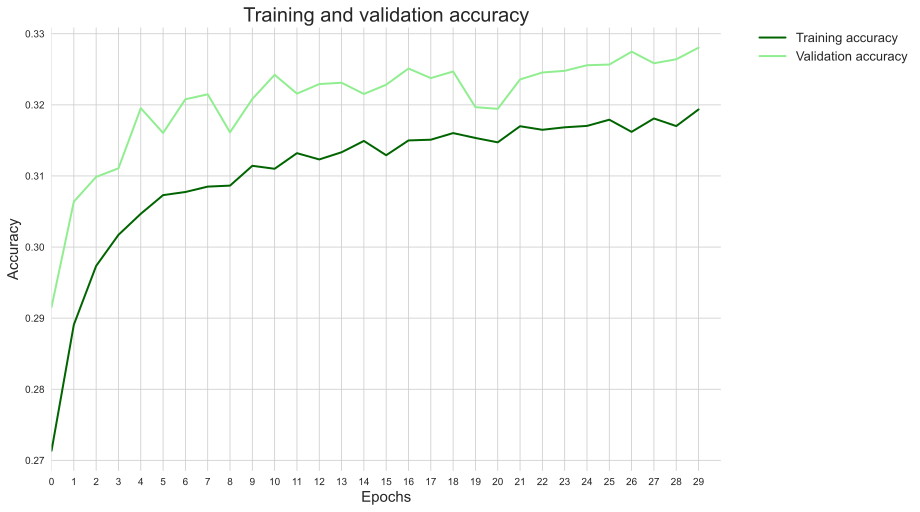

In [25]:
plot_metric_curves(epochs, acc, val_acc, "darkgreen", "lightgreen", "Accuracy", 1)

Esta gráfica muestra que la precisión de entrenamiento y de validación mejora de manera constante (aunque algo fluctuante), lo cual es lo que se espera de un modelo que está aprendiendo de los datos. 

La precisión de validación es ligeramente superior a la de entrenamiento, por lo que el modelo está prediciendo los nuevos datos con mayor precisión que los datos de entrenamiento.

Al igual que con la gráfica de pérdida, la diferencia entre el valor de entrenamiento y validación no es tan grande como para considerar que el modelo está sobreajustado. 

# Predicciones

In [26]:
# Predecir las emociones en el conjunto de validación
y_pred_probs = model.predict(val_padded)
y_val_label_encoded = np.argmax(y_val_encoded, axis=1)
y_val_labels = label_encoder.inverse_transform(y_val_label_encoded)


emotion_labels = label_encoder.classes_

673/673 [==============================] - 2s 2ms/step


In [27]:
emotion_to_emoji = {
    'admiration': '🤩',
    'amusement': '😄',
    'anger': '😡',
    'annoyance': '😑',
    'approval': '👍',
    'caring': '🥰',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😏',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤢',
    'embarrassment': '😳',
    'excitement': '😃',
    'fear': '😨',
    'gratitude': '🙏',
    'joy': '😀',
    'love': '❤️',
    'neutral': '😐',
    'optimism': '😊',
    'realization': '😲',
    'sadness': '😢',
    'surprise': '😮'
}

In [28]:
# Dataframe con texto, emoción real y top 3 de emociones predichas con sus probabilidades
df_results = pd.DataFrame(columns=['text', 'top1', 'top2', 'top3'])
df_results['text'] = X_val

# Obtener las etiquetas de las emociones predichas
top1_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -1]]
top2_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -2]]
top3_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -3]]

# Mapear las emociones a emojis
top1_labels = [emotion_to_emoji[label] for label in top1_labels]
top2_labels = [emotion_to_emoji[label] for label in top2_labels]
top3_labels = [emotion_to_emoji[label] for label in top3_labels]

# Obtener las probabilidades de las emociones predichas
top1_probs = y_pred_probs.max(axis=1) * 100  # Multiplicar por 100 para obtener el porcentaje
top2_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -2]] * 100
top3_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -3]] * 100

# Asignar valores al DataFrame
df_results['top1'] = [f'{label} {prob:.0f}%' for label, prob in zip(top1_labels, top1_probs)]
df_results['top2'] = [f'{label} {prob:.0f}%' for label, prob in zip(top2_labels, top2_probs)]
df_results['top3'] = [f'{label} {prob:.0f}%' for label, prob in zip(top3_labels, top3_probs)]

# Resetear el índice
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,text,top1,top2,top3
0,Maybe could put context wa responding someone ...,😐 33%,😑 10%,👎 10%
1,NAME like picking choosing life work fact work,😐 41%,👍 11%,😲 6%
2,How people eat paper plate theyre bbq,😐 32%,🤔 16%,😕 14%
3,Thank voice reason people keep screaming Vatic...,🙏 17%,😐 14%,😑 11%
4,Gotta love trailing minute,❤️ 33%,😐 17%,🤩 15%
